In [2]:
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
input_img = keras.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(
                filters=32,
                kernel_size=3,
                strides=(2, 2),
                padding="valid",
                activation="relu",
            )(input_img)
x = layers.Conv2D(
                filters=64,
                kernel_size=3,
                strides=(2, 2),
                padding="valid",
                activation="relu",
            )(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
encoded = layers.Dense(20)(x)

# Decoder
decoder_input = layers.InputLayer(input_shape=20)(encoded)
x = layers.Dense(128, activation="relu")(decoder_input)
x = layers.Dense(7*7*32, activation="relu")(x)
x = layers.Reshape((7, 7, 32))(x)
x = layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding="same", activation="relu"
            )(x)
x = layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding="same", activation="relu"
            )(x)
decoded = layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding="same", activation="sigmoid")(x)


autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.save_weights('initial_model.h5')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 13, 13, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               295040    
                                                                 
 dense_1 (Dense)             (None, 20)                2580      
                                                                 
 dense_2 (Dense)             (None, 128)               2688  

2022-03-01 19:05:28.201180: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from stacked_mnist import StackedMNISTData, DataMode
import numpy as np

generator = StackedMNISTData(mode=DataMode.MONO_BINARY_MISSING, default_batch_size=2048)

x_train, y_train = generator.get_full_data_set(training=True)
x_test, y_test = generator.get_full_data_set(training=False)

# "Translate": Only look at "red" channel; only use the last digit. Use one-hot for labels during training
x_train = x_train[:, :, :, [0]]
y_train = keras.utils.to_categorical((y_train % 10).astype(np.int), 10)
x_test = x_test[:, :, :, [0]]
y_test = keras.utils.to_categorical((y_test % 10).astype(np.int), 10)

/var/folders/w2/4g3c4yrn38g2nwwdhjdlx6fc0000gn/T/ipykernel_2302/1236489056.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = keras.utils.to_categorical((y_train % 10).astype(np.int), 10)
/var/folders/w2/4g3c4yrn38g2nwwdhjdlx6fc0000gn/T/ipykernel_2302/1236489056.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precisi

In [5]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
424/424 [==============================] - 30s 68ms/step - loss: 0.1817 - val_loss: 0.1047
Epoch 2/10
424/424 [==============================] - 28s 67ms/step - loss: 0.0765 - val_loss: 0.0750
Epoch 3/10
424/424 [==============================] - 31s 72ms/step - loss: 0.0621 - val_loss: 0.0659
Epoch 4/10
424/424 [==============================] - 31s 73ms/step - loss: 0.0562 - val_loss: 0.0608
Epoch 5/10
424/424 [==============================] - 31s 74ms/step - loss: 0.0526 - val_loss: 0.0627
Epoch 6/10
424/424 [==============================] - 29s 67ms/step - loss: 0.0504 - val_loss: 0.0588
Epoch 7/10
424/424 [==============================] - 28s 67ms/step - loss: 0.0485 - val_loss: 0.0582
Epoch 8/10
424/424 [==============================] - 28s 65ms/step - loss: 0.0472 - val_loss: 0.0578
Epoch 9/10
424/424 [==============================] - 30s 71ms/step - loss: 0.0461 - val_loss: 0.0537
Epoch 10/10
424/424 [==============================] - 29s 69ms/step - loss: 0.045

In [6]:
generator_full = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)
x_test, y_test = generator.get_full_data_set(training=False)

# "Translate": Only look at "red" channel; only use the last digit. Use one-hot for labels during training
x_train = x_train[:, :, :, [0]]
x_test = x_test[:, :, :, [0]]

In [17]:
reconstructed = autoencoder(x_test)
bce = keras.losses.BinaryCrossentropy()
losses = []
for i in range(x_test.shape[0]):
    losses.append(bce(x_test[i], reconstructed[i]).numpy())
losses = np.array(losses)
ind = np.argpartition(losses, -10)[-10:] # Get the indices of the 10 largest losses

NameError: name 'x_test' is not defined

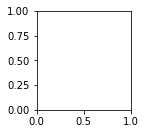

In [1]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[ind[i-1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()